In [2]:
import numpy as np
import scipy.integrate
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Week 9 Lecture 2: Nonlineardynamics, Bifurcations, and Chaos
## Rahman notes:
### Chaos

While we can't run the numerics on a chaotic system indefinitely, we can for some reasonable amount of time.  For the Lorenz equation, we can do this until about t = 35.

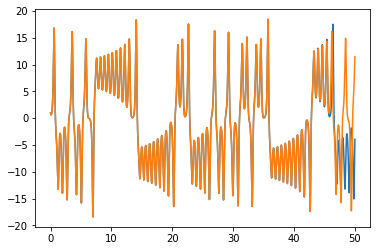

In [14]:
dt = 0.01
T = 50
t = np.arange(0, T + dt, dt)

sigma = 10
beta = 8/3
rho = 28

def Lorenzeq(t, x):

  dx1 = -sigma*x[0] + sigma*x[1]
  dx2 = rho*x[0] - x[1] - x[0]*x[2]
  dx3 = -beta*x[2] + x[0]*x[1]

  dx = np.array([dx1, dx2, dx3])
  return dx

x0 = np.array([1, 0, 20])
sol = scipy.integrate.solve_ivp(Lorenzeq, (0, T), x0, t_eval=t)
x1 = sol.y[0,:]
y1 = sol.y[1,:]
z1 = sol.y[2,:]

x0 = np.array([1+1e-15, 0, 20])
sol = scipy.integrate.solve_ivp(Lorenzeq, (0, T), x0, t_eval=t)
x2 = sol.y[0,:]
y2 = sol.y[1,:]
z2 = sol.y[2,:]

plt.plot(t, x1)
plt.plot(t,x2)

After time $t\approx 35$, the two solutions are completely different.  

Unfortunately, most important physical systems are chaotic.  It might sound like this is a hopeless situation - It seems that we can't trust approximations to most interesting physical systems.  However, the situation is not as dire as it might seem.  While we can't trust the exact values of $x$ or $y$ or $z$, we can trust more general features of the solution.  In particular, the phase diagram for our approximations really is converging to the correct shape.  

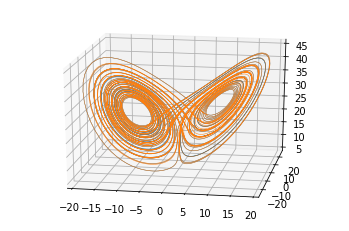

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.plot(x1, y1, z1, linewidth=0.5)
plt.plot(x2, y2, z2, linewidth=0.5)
ax.view_init(20, -80)

This is one of the reasons why we spent so much time worrying about stability.  If your differential equation is chaotic, then after some time it doesn't really matter how accurate your solver is.  The best you can hope for is to capture the long term stable behavior of the solution.  In that case, you care much more about the stability properties of your solver than the accuracy.  Remember that implicit methods are generally better at capturing this stable behavior with a larger time step.  This means that if you want to know the long-term behavior of a chaotic system, you may be better off using an implicit method like backward Euler or a builtin solver with an implicit method like `solve_ivp` with the option `method='Radau'` instead of a high accuracy solver like RK4.  

Now lets take a step back and see what happens if we change our parameters.

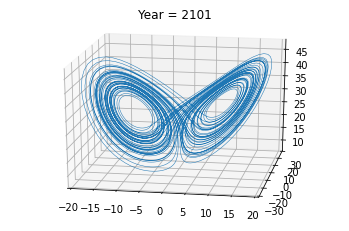

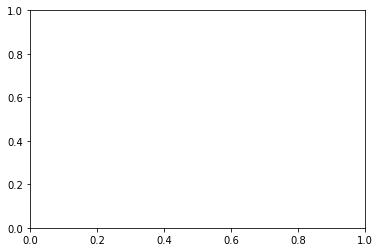

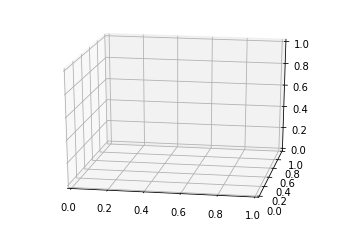

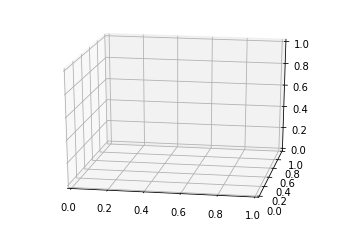

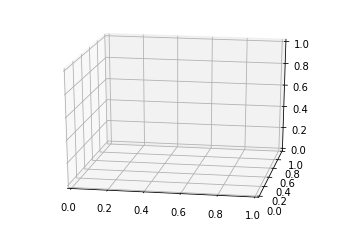

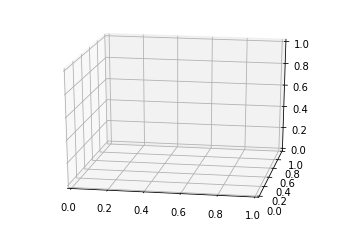

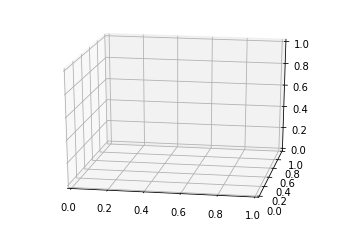

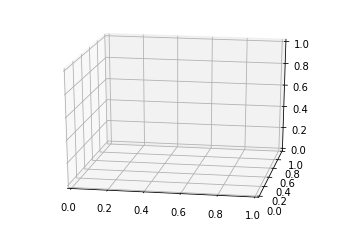

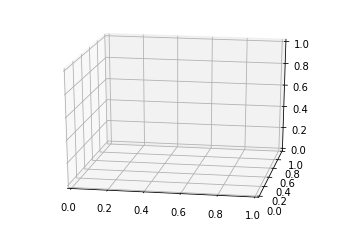

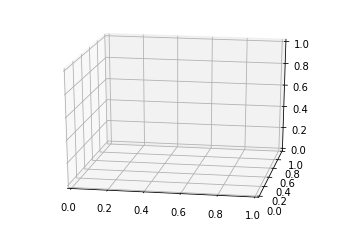

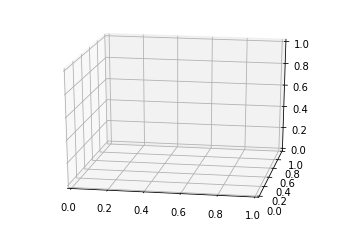

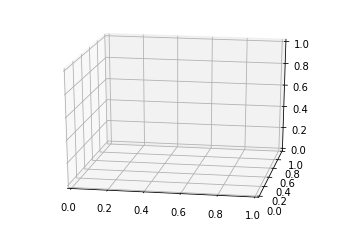

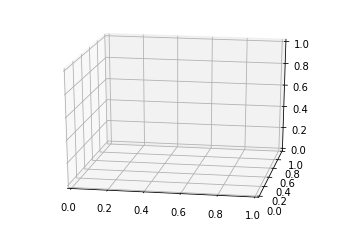

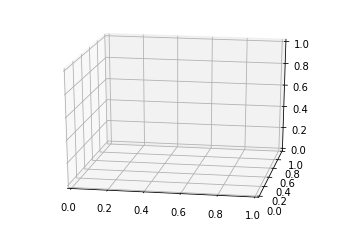

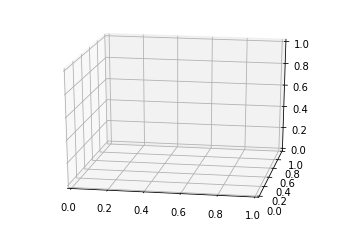

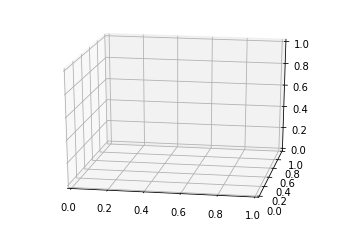

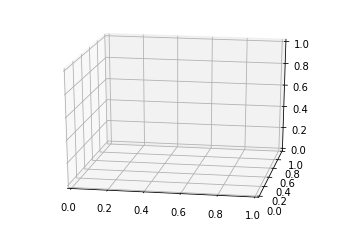

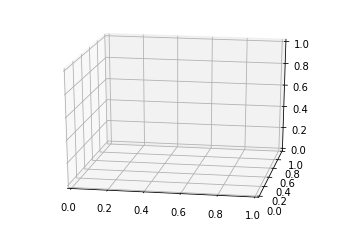

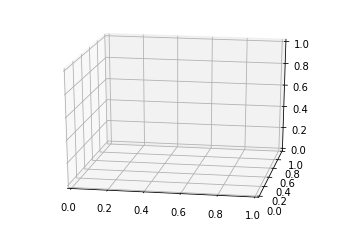

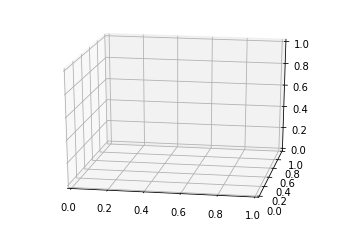

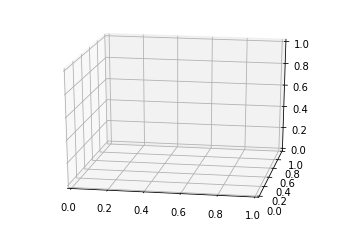

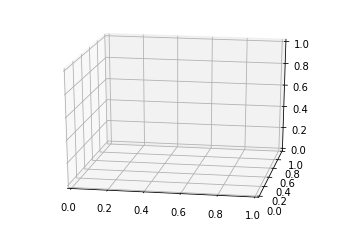

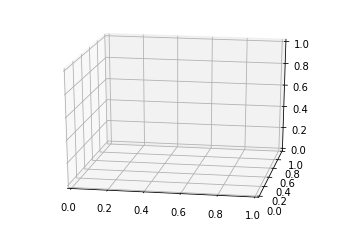

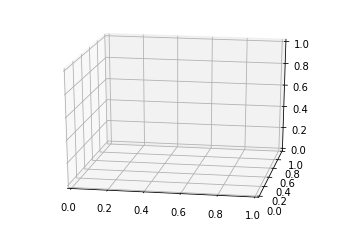

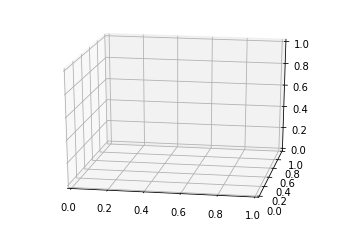

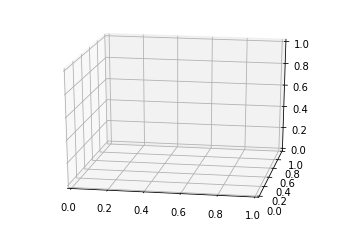

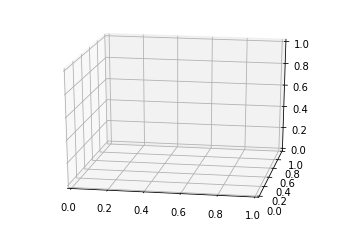

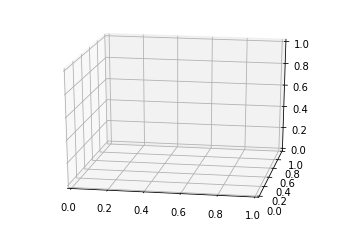

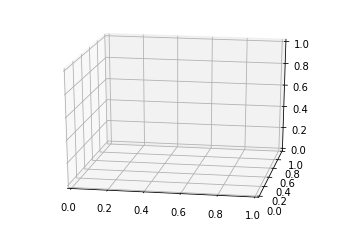

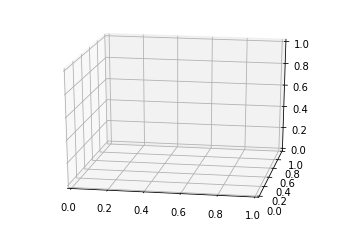

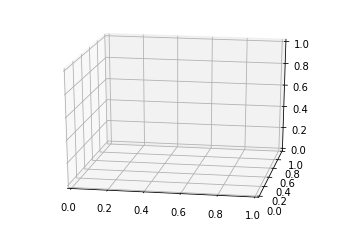

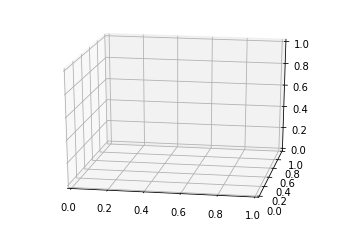

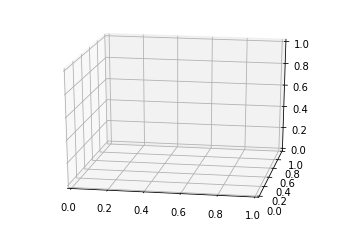

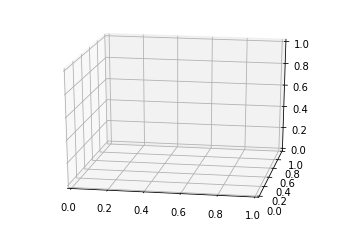

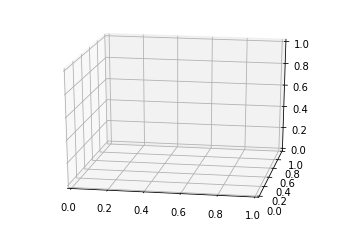

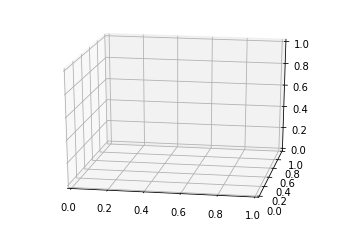

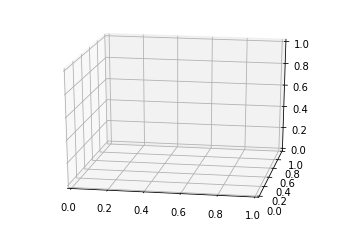

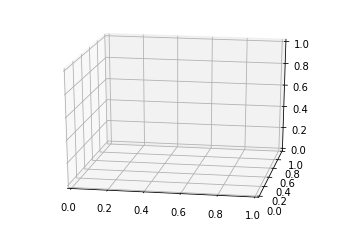

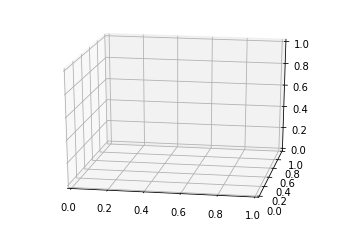

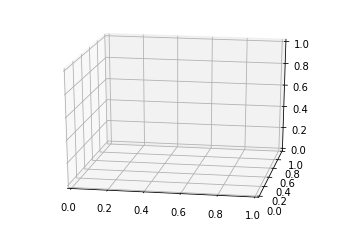

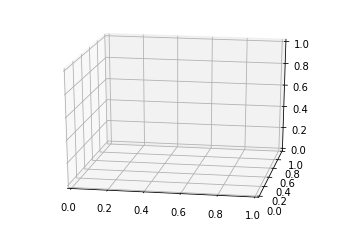

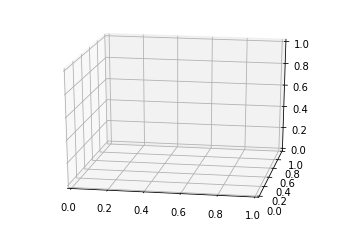

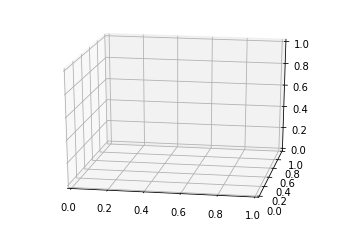

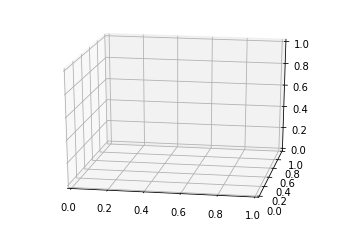

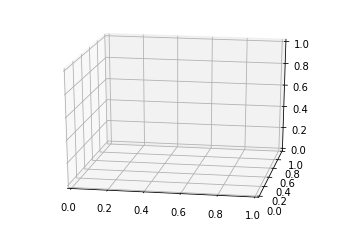

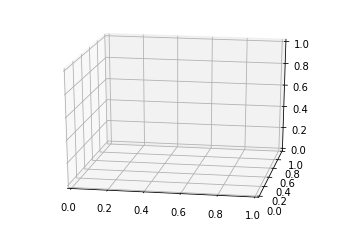

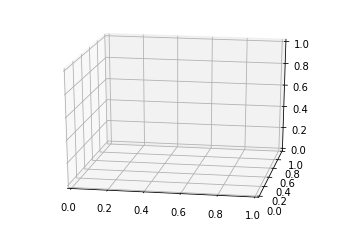

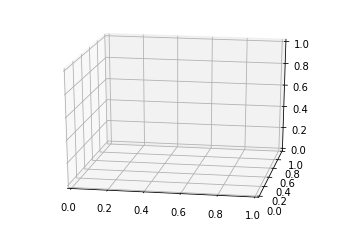

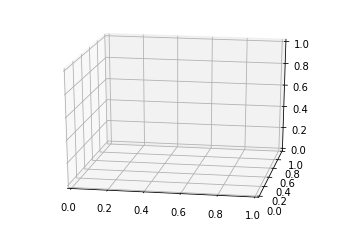

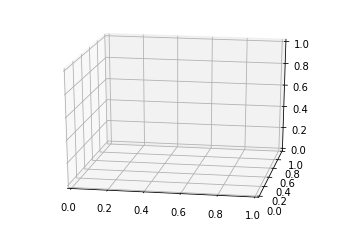

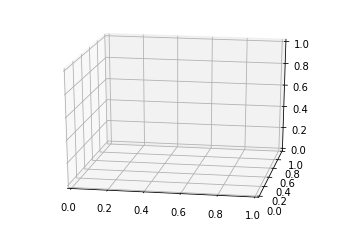

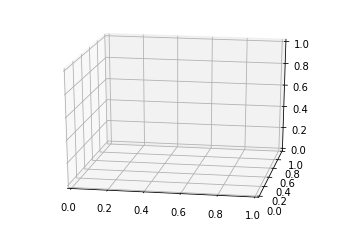

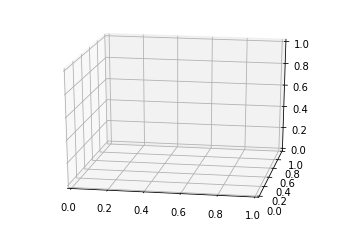

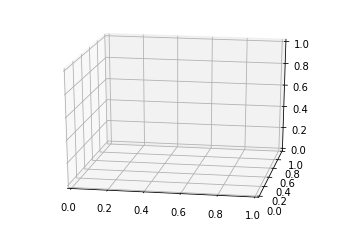

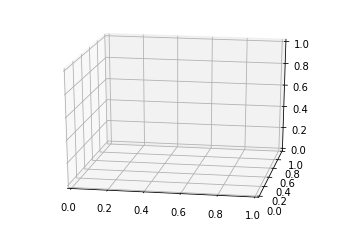

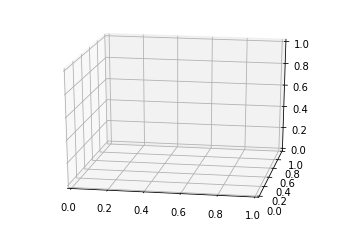

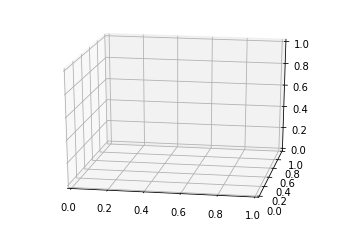

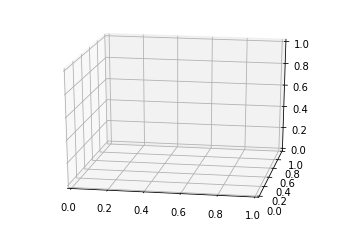

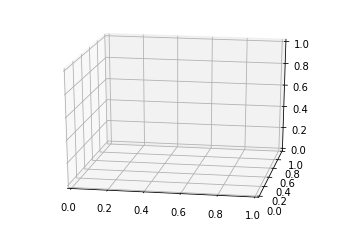

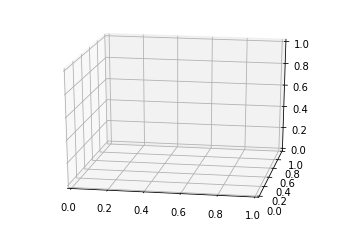

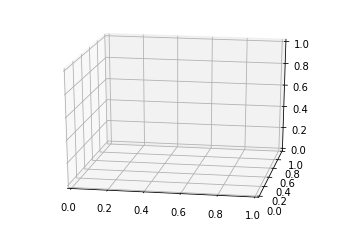

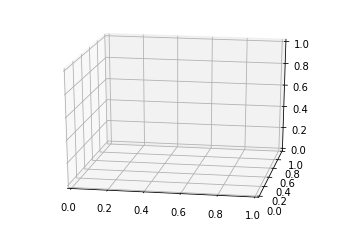

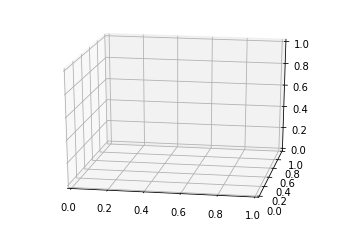

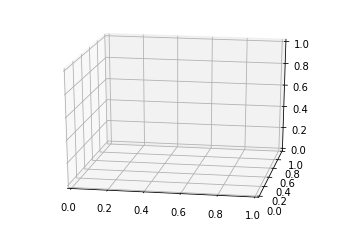

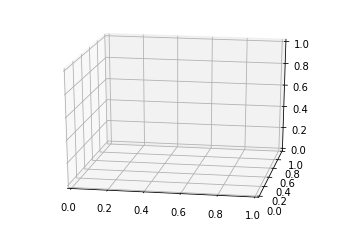

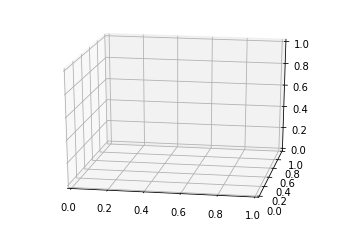

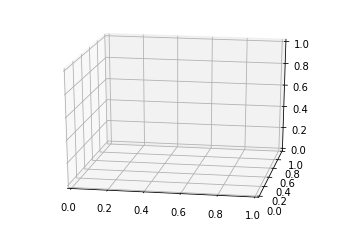

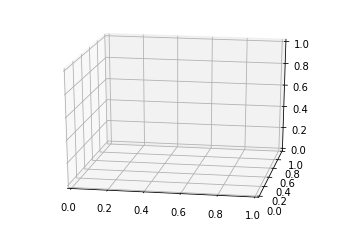

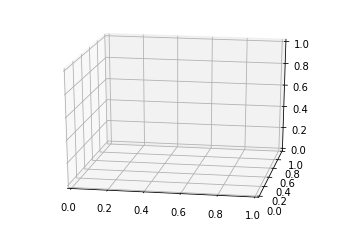

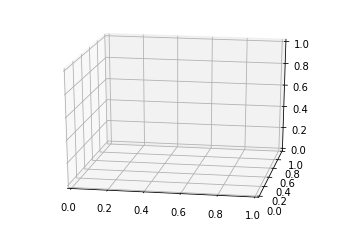

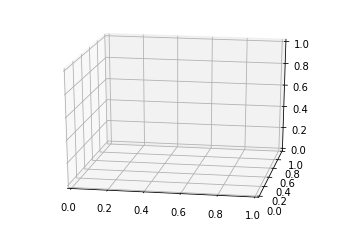

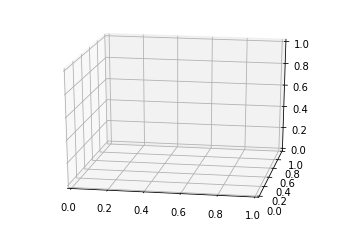

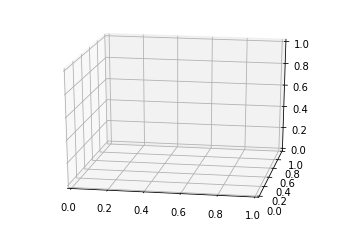

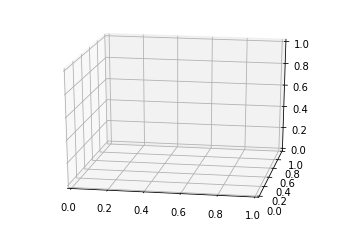

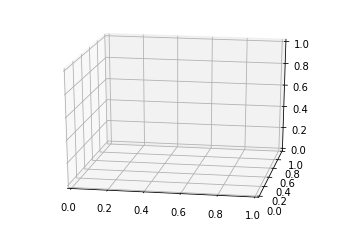

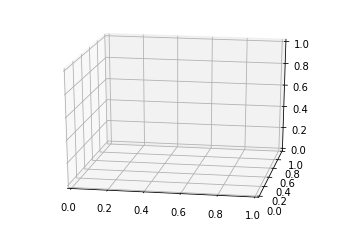

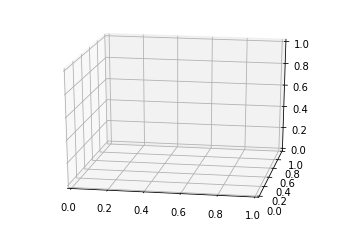

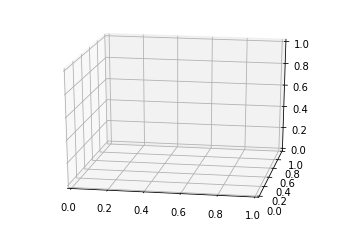

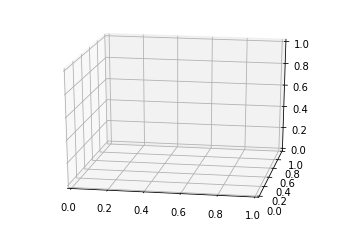

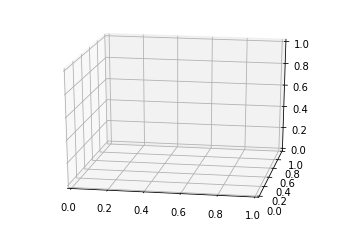

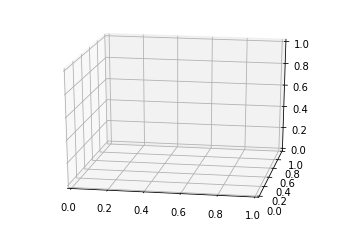

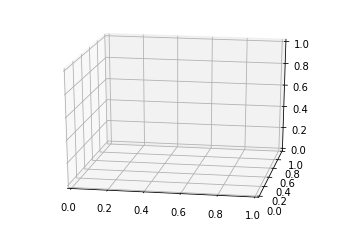

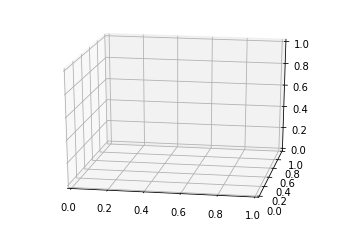

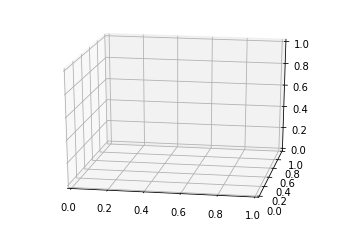

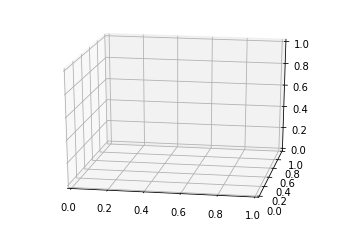

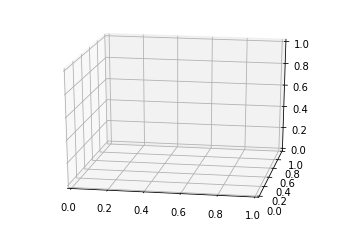

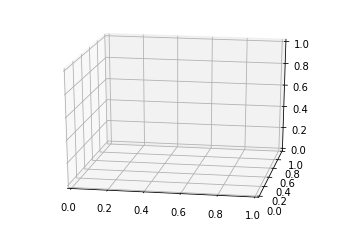

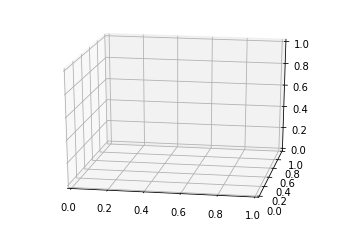

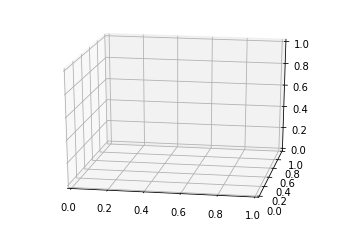

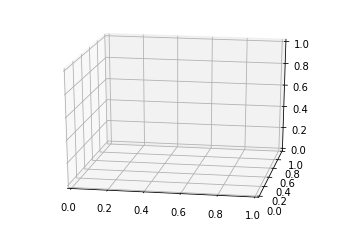

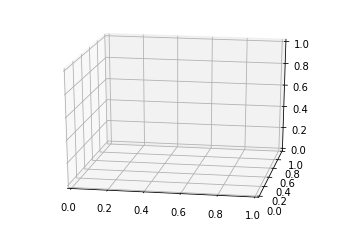

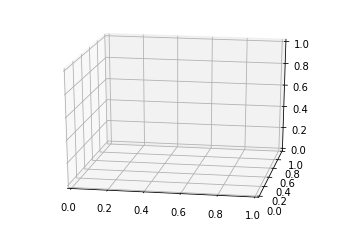

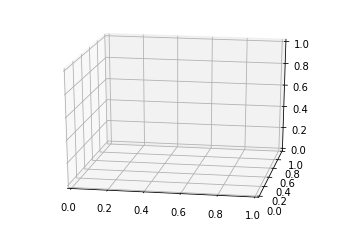

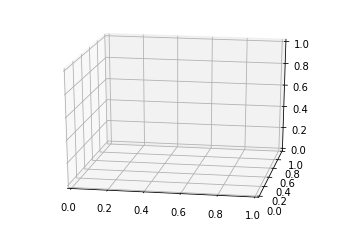

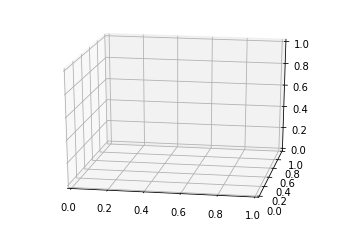

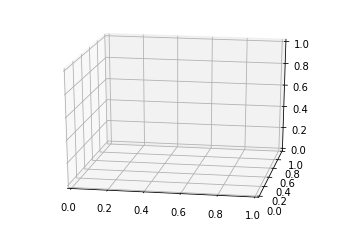

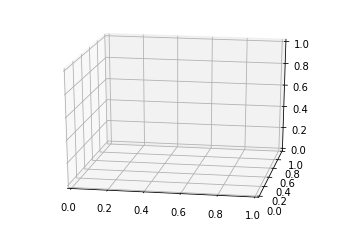

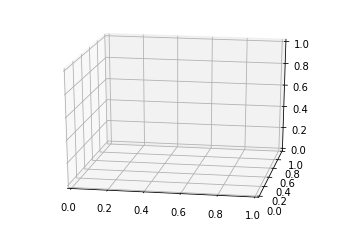

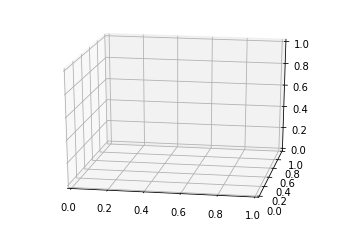

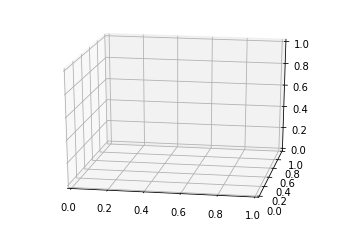

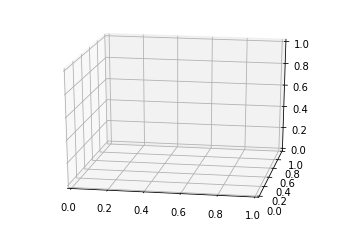

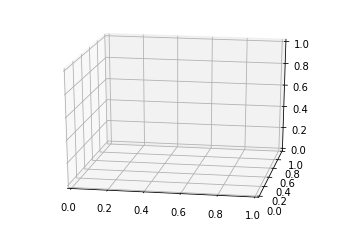

Error in callback <function flush_figures at 0x7f12470a0440> (for post_execute):


KeyboardInterrupt: ignored

In [30]:
import time
from IPython import display

dt = 0.01
T = 50
t = np.arange(0, T + dt, dt)

sigma = 10
beta = 8/3
rho = np.arange(28, 30+0.01, 0.01)

def Lorenzeq(t, x, params):
  sigma = params[0]
  beta = params[1]
  rho = params[2]

  dx1 = -sigma*x[0] + sigma*x[1]
  dx2 = rho*x[0] - x[1] - x[0]*x[2]
  dx3 = -beta*x[2] + x[0]*x[1]

  dx = np.array([dx1, dx2, dx3])
  return dx

x0 = np.array([1, 0, 20])

for i in range(np.size(rho)):
  params = np.array([sigma, beta, rho[i]])
  Lorenz = lambda t, x: Lorenzeq(t, x, params)
  sol = scipy.integrate.solve_ivp(Lorenz, (0, T), x0, t_eval=t)
  x = sol.y[0,:]
  y = sol.y[1,:]
  z = sol.y[2,:]
  plt.cla()
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  plt.plot(x, y, z, linewidth=0.5)
  plt.axis([-20, 20, -30, 30])
  ax.view_init(20, -80)
  year = 1900+i
  plt.title('Year = %i' %year)
  display.clear_output(wait=True)
  display.display(plt.gcf())

plt.cla()

## Stiff Differential Equations
There is one other situation where implicit solvers can outperform explicit solvers.  To illustrate, let's look at an extremely simplified model for the growth of a spark into a ball of flame.  The flame grows because it comes into contact with more oxygen at its surface, and it shrinks because it consumes oxygen in its interior.  This means that the rate of growth should be proportional to the surface area of the flame and the rate of decay should be proportional to the volume.  This gives us the (highly oversimplified) differential equation 

$\dot{x} = x^2 - x^3$.  

Here, $x$ is some measure of the size of the flame.  Since the flame starts out as a spark, $x(0) = \delta$ should be very small.  This model can be solved exactly, and it turns out that the solution stays almost flat at $x = \delta$ for a very long time, then at time $1/\delta$ it suddenly jumps to $x = 1$.  The solution is monotonically increasing, so it should never oscillate up and down.  Let's try solving this IVP with `solve_ivp` with the default method.  (Remember that the default method is based on RK4, which is an explicit method.)

In [ ]:
f = lambda t, x: x ** 2 - x ** 3
delta = 1e-5
x0 = np.array([delta])
tspan = (0, 2 / delta)

t0 = time.time()
sol = scipy.integrate.solve_ivp(f, tspan, x0)
t1 = time.time()

t = sol.t
x = sol.y[0, :]
plt.figure(figsize=(16, 4))
plt.plot(t, x, 'k')

This code took 

In [ ]:
print(t1 - t0)

seconds to run, which is relatively slow.  It's hard to tell from this picture, but it also did quite a bad job at approximating the shape of the solution.  To see what's going on, let's zoom in on part of the graph near the middle.  

In [ ]:
plt.plot(t, x, 'k')
plt.xlim((1 / delta + 20, 1 / delta + 200))
plt.ylim((0.998, 1))

As you can see, the solution is wildly oscillating up and down instead of staying almost flat as it is supposed to.  

The problem is that this differential equation is *stiff*.  There is not a particularly good standard definition of stiffness in differential equations, but the key idea is that the solution operates on two (or more) very different time scales.  In our example, the solution changes very slowly most of the time, but there is a moment in the middle when it changes very suddenly.  It turns out that explicit solvers have a very difficult time with stiff differential equations.  They require a very small time step, and oscillations like this are very common.  However, implicit solvers are typically very good at solving stiff problems.  For example, we could use `solve_ivp` with the Radau method, which is an implicit solver.  

In [ ]:
f = lambda t, x: x ** 2 - x ** 3
delta = 1e-5
x0 = np.array([delta])
tspan = (0, 2 / delta)

t0 = time.time()
sol = scipy.integrate.solve_ivp(f, tspan, x0, method='Radau')
t1 = time.time()

t = sol.t
x = sol.y[0, :]
plt.figure(figsize=(16, 4))
plt.plot(t, x, 'k')

This code took only

In [ ]:
print(t1 - t0)

seconds to run, and if we zoom in on the same region we can see that it did a much better job of capturing the correct behavior.  

In [ ]:
plt.plot(t, x, 'k')
plt.xlim((1 / delta + 20, 1 / delta + 200))
plt.ylim((0.998, 1.001))